In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from nltk.tokenize import TweetTokenizer
import emoji
from wordcloud import WordCloud

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [2]:
# train = pd.read_csv(r'train_dataset.csv')
# val = pd.read_csv(r'val_dataset.csv')
# test = pd.read_csv(r'test_dataset.csv')

train = pd.read_csv(r'/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv')
val = pd.read_csv(r'/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv')
test = pd.read_csv(r'/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/test_dataset.csv')

#### Exploratory Data Analysis

Define a helper function to find the largest word in a dataframe and calculate the average number of words in its sentences

In [3]:
def statistics(df):  
    result = []  # A list that will hold the largest word in every sentence. It will help determine the largest word overall
    average = 0  # Used to calculate the average number of words in a sentence
    unique_words = set()  # A set that will hold all the words in the dataframe. It will help determine the number of unique words

    for sentence in df['Text']:
        # Skip this line if its empty
        if len(sentence) == 0:
            continue
        
        words = sentence.split()
        unique_words.add(word for word in words)

        average += len(words)
        max_word = max(words, key=len)
        result.append(max_word)

    average /= df.shape[0]

    print("The largest word in the given dataframe is: ", max(result, key=len))
    print("The average number of words in a sentence is: %.2f" % average)
    print("The number of unique words is: ", len(unique_words))

Print the dataframes' column types. Each of them has an ID column of integers and a Text column with strings. The training and validation datasets also have the Label column, that contains integers.

In [4]:
print("Training Dataset:\n",train.dtypes,"\n\n",
      "Validation Dataset:\n",val.dtypes,"\n\n",
      "Testing Dataset:\n",test.dtypes)

Training Dataset:
 ID        int64
Text     object
Label     int64
dtype: object 

 Validation Dataset:
 ID        int64
Text     object
Label     int64
dtype: object 

 Testing Dataset:
 ID       int64
Text    object
dtype: object


Check that none of the datasets contain empty lines

In [5]:
print("Training Dataset\n", train.isnull().sum(), "\n\n",
      "Validation Dataset\n",val.isnull().sum(), "\n\n",
      "Testing Dataset\n",test.isnull().sum())

Training Dataset
 ID       0
Text     0
Label    0
dtype: int64 

 Validation Dataset
 ID       0
Text     0
Label    0
dtype: int64 

 Testing Dataset
 ID      0
Text    0
dtype: int64


Check the datasets' dimentions

In [6]:
print("Training dataset shape: ", train.shape, "\r\n", 
      "Validation dataset shape: ", val.shape, "\n",
      "Testing dataset shape: ", test.shape)

Training dataset shape:  (148388, 3) 
 Validation dataset shape:  (42396, 3) 
 Testing dataset shape:  (21199, 2)


Upon printing a sample of the dataframes, it's apparent that the ID column contains a unique identifier, the Text column contains the body of the tweet and the Label column contains the tweet's sentiment (0 if negative, 1 if positive)

In [7]:
train.head()

,ID,Text,Label
0,189385,@whoisralphie dude I'm so bummed ur leaving!,0
1,58036,"oh my god, a severed foot was foun in a wheely...",0
2,190139,I end up &quot;dog dialing&quot; sumtimes. Wha...,1
3,99313,@_rachelx meeeee toooooo!,0
4,157825,"I was hoping I could stay home and work today,...",0


Draw a histogram of the labels. We can see that the data is balanced, which will help our model be less biased

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


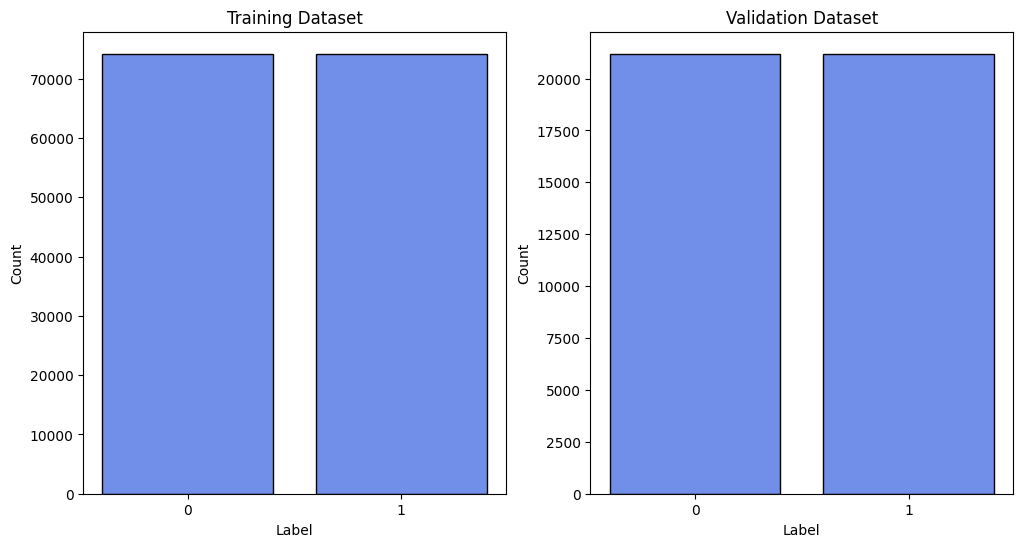

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

train_hist = sns.histplot(ax = ax[0], data=train['Label'], discrete=True, shrink=.8, color='royalblue')
train_hist.set_xticks(range(0,2))
train_hist.set_title("Training Dataset")

val_hist = sns.histplot(ax = ax[1], data=val['Label'], discrete=True, shrink=.8, color='royalblue')
val_hist.set_xticks(range(0,2))
val_hist.set_title("Validation Dataset")

plt.show()

Call the statistics function

In [9]:
print("--- Training Dataset ---")
statistics(train)
print()
print("--- Validation Dataset ---")
statistics(val)
print()
print("--- Testing Dataset ---")
statistics(test)

--- Training Dataset ---
The largest word in the given dataframe is:  CheeseRavioli+Zitty+Dirk+PaperAirplanes+SportsCoats+Sex+PushPlayGroupieWannabes+GirlShoes+MyspaceWhores+MakingFunOfBands+Music=GOODTIMES!
The average number of words in a sentence is: 13.29
The number of unique words is:  148388

--- Validation Dataset ---
The largest word in the given dataframe is:  ??????????????????????????????????????????????????????????????????????????????????..
The average number of words in a sentence is: 13.31
The number of unique words is:  42396

--- Testing Dataset ---
The largest word in the given dataframe is:  bbbbbbbbooooooooooooooooooooooooooooooorrrrrrrrrrrrrrrrrrrrrrrrrrrrreeeeeeeeeeeeeeeeeddddddddddddddddddddddd...
The average number of words in a sentence is: 13.36
The number of unique words is:  21199


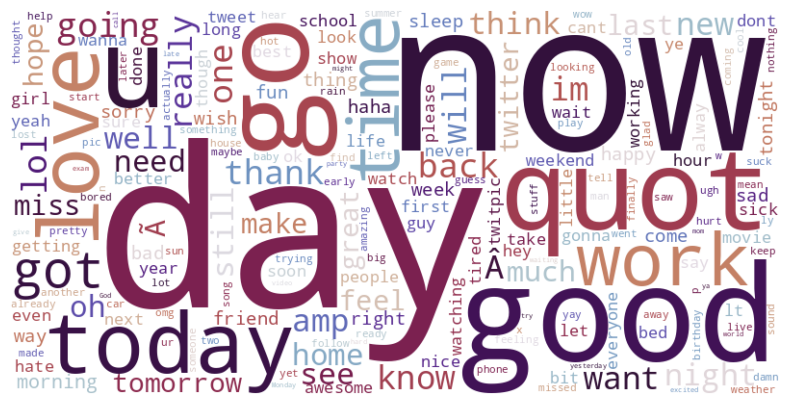

In [10]:
text = ' '.join(train['Text'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='twilight', collocations=False).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

Print 10 of the tweets from the training dataset. We observe the following:
* typos and synoptic words
* alternations in capitalization 
* presence of punctuation marks, numbers and characters other than Latin alphabet
* HTML reference characters (e.g. " is represented as \&quot\?)
* URLs 
* twitter handles

These will interfere with our model, so they will be fixed in preprocessing

In [11]:
for i in range(10):
    print(train['Text'][i])

@whoisralphie dude  I'm so bummed ur leaving!
oh my god, a severed foot was foun in a wheely bin in cobham!!! where they found is literally minutes from my house! feel sick now! 
I end up &quot;dog dialing&quot; sumtimes. What's dog dialing, u ask?My dogs will walk across my phone &amp; end up calling someone. aka &quot;dog dialing&quot;! 
@_rachelx meeeee toooooo! 
I was hoping I could stay home and work today, but looks like I have to make another trip into town 
says plurk karma finally reached the 50s. still no heartsy smileys. boo.  http://plurk.com/p/z2x3y
Good to hear it @Arth This is a bit more, but a la four tet  Do you know Free Rotation festival? Am thinking ... Ã¢â¢Â« http://blip.fm/~7hcvo
@davorg in that case im gonna start tweeting about nymphomanic pub owners who like to cook, well worth a shot, eh 
@belunyc its alright love, how are you?  
@brightondoll haha that has to be the best analogy ever. mogwai to gremlin. love it. i love gizmo and the gremlins movies 


#### Base Case

We start with a base case: create a TD-IDF matrix and call the logistic regression classifier without using any parameters.

In [12]:
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(train['Text'])
x_val_tfidf = vectorizer.transform(val['Text'])

model = LogisticRegression(random_state=42)
model.fit(x_train_tfidf, train['Label'])
prediction = model.predict(x_val_tfidf)

accuracy = accuracy_score(val['Label'], prediction)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(val['Label'], prediction))

conf = confusion_matrix(val['Label'], prediction)
print(f"Confusion Matrix: \n{conf}")

Accuracy: 0.7909
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79     21197
           1       0.79      0.80      0.79     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396

Confusion Matrix: 
[[16674  4523]
 [ 4342 16857]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Plot the training curve

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

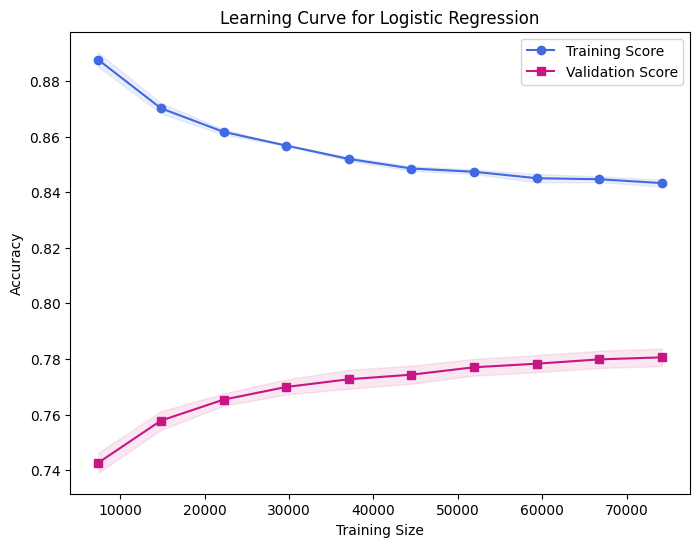

In [13]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(model, x_train_tfidf, train['Label'], cv=2, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10))
# Compute mean and std of accuracy
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="royalblue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="royalblue")

plt.plot(train_sizes, test_mean, label="Validation Score", color="mediumvioletred", marker="s")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="mediumvioletred")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Logistic Regression")
plt.legend()
plt.show()

We can achieve a high accuracy score (0.79) without any preprocessing. This is partially thanks to our data being balanced

#### Text Preprocessing

In [14]:
# Store the clean datasets in different variables so we don't mess with the initial data
train_clean = train
val_clean = val
test_clean = test

Replace emojis with their respective descriptive word/phrase

In [15]:
train_clean['Text'] = train_clean.Text.apply(emoji.demojize)
val_clean['Text'] = val_clean.Text.apply(emoji.demojize)
test_clean['Text'] = test_clean.Text.apply(emoji.demojize)

Convert all text to lowercase

In [16]:
train_clean['Text'] = train_clean.Text.str.lower()
val_clean['Text'] = val_clean.Text.str.lower()
test_clean['Text'] = test_clean.Text.str.lower()

Remove all HTML reference characters

In [17]:
train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'&[a-z]+;', '', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'&[a-z]+;', '', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'&[a-z]+;', '', x))

Replace all links to websites (either http(s):// or www. links) with the word 'LINK'

In [18]:
train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'http(s)?\:\/\/\S+', 'LINK', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'https?:\/\/\S+', 'LINK', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'https?:\/\/\S+', 'LINK', x))

train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'www\.\S+\.[a-z]+', 'LINK', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'www\.\S+\.[a-z]+', 'LINK', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'www\.\S+\.[a-z]+', 'LINK', x))

Replace emails with the word 'EMAIL' for privacy reasons

In [19]:
train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'\S+@\w+.\w+', 'EMAIL', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'\S+@\w+.\w+', 'EMAIL', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'\S+@\w+.\w+', 'EMAIL', x))

Replace twitter handles with the word 'NAME' for privacy reasons

In [20]:
train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'@\S+', 'NAME', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'@\S+', 'NAME', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'@\S+', 'NAME', x))

Remove all special characters

In [21]:
train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

Remove all non-ASCII characters

In [22]:
train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'[^\x00-\x7F]', '', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'[^\x00-\x7F]', '', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'[^\x00-\x7F]', '', x))

Replace multiple instances (>2) of the same character in a row with just two of them

In [23]:
train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'(\w)\1+', r'\1\1', x))
val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'(\w)\1+', r'\1\1', x))
test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'(\w)\1+', r'\1\1', x))

The 'Text' column is now as follows:

In [24]:
for i in range(10):
    print(train_clean['Text'][i])

NAME dude  i m so bummed ur leaving 
oh my god  a severed foot was foun in a wheely bin in cobham    where they found is literally minutes from my house  feel sick now  
i end up dog dialing sumtimes  what s dog dialing  u ask my dogs will walk across my phone  end up calling someone  aka dog dialing  
NAME mee too  
i was hoping i could stay home and work today  but looks like i have to make another trip into town 
says plurk karma finally reached the 50s  still no heartsy smileys  boo   LINK
good to hear it NAME this is a bit more  but a la four tet  do you know free rotation festival  am thinking          LINK
NAME in that case im gonna start tweeting about nymphomanic pub owners who like to cook  well worth a shot  eh 
NAME its alright love  how are you   
NAME haha that has to be the best analogy ever  mogwai to gremlin  love it  i love gizmo and the gremlins movies 


Use lemmatization

In [25]:
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(lemmatized_words)

train_clean['Text'] = train_clean['Text'].apply(lemmatize)
val_clean['Text'] = val_clean['Text'].apply(lemmatize)
test_clean['Text'] = test_clean['Text'].apply(lemmatize)

The 'Text' column is now as follows:

In [26]:
for i in range(10):
    print(train_clean['Text'][i])

NAME dude i m so bummed ur leaving
oh my god a severed foot wa foun in a wheely bin in cobham where they found is literally minute from my house feel sick now
i end up dog dialing sumtimes what s dog dialing u ask my dog will walk across my phone end up calling someone aka dog dialing
NAME mee too
i wa hoping i could stay home and work today but look like i have to make another trip into town
say plurk karma finally reached the 50 still no heartsy smiley boo LINK
good to hear it NAME this is a bit more but a la four tet do you know free rotation festival am thinking LINK
NAME in that case im gonna start tweeting about nymphomanic pub owner who like to cook well worth a shot eh
NAME it alright love how are you
NAME haha that ha to be the best analogy ever mogwai to gremlin love it i love gizmo and the gremlin movie


Call the statistics function one more time for comparison

In [27]:
print("--- Training Dataset ---")
statistics(train_clean)
print()
print("--- Validation Dataset ---")
statistics(val_clean)
print()
print("--- Testing Dataset ---")
statistics(test_clean)

--- Training Dataset ---
The largest word in the given dataframe is:  youthinkimkiddingimfuckingseriousiamhavingmeatloafwithdrawalsandamthisclosetorobbingameatloafrestaurant
The average number of words in a sentence is: 13.67
The number of unique words is:  148388

--- Validation Dataset ---
The largest word in the given dataframe is:  whyareallthegoodmedscontrolledsubstances
The average number of words in a sentence is: 13.69
The number of unique words is:  42396

--- Testing Dataset ---
The largest word in the given dataframe is:  unfollowanyonewhoisfollowingoprahcampaign2009
The average number of words in a sentence is: 13.76
The number of unique words is:  21199


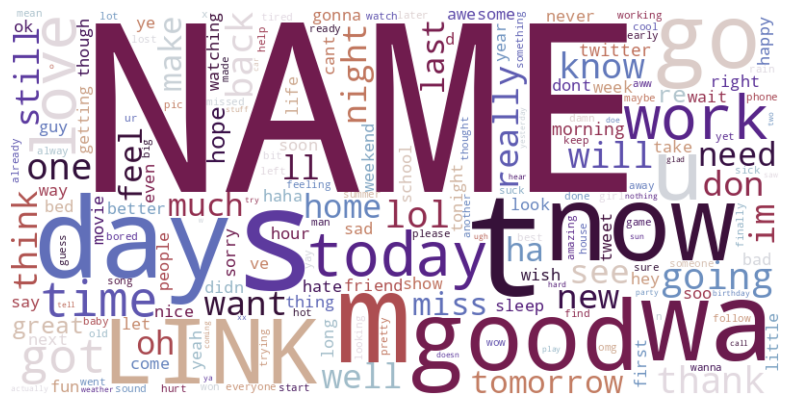

In [28]:
text = ' '.join(train_clean['Text'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='twilight', collocations=False).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

Train the model again now that the preprocessing is done. Continue to use the default parameters for TF-IDF vectorization and logistic regression.

In [29]:
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(train_clean['Text'])
x_val_tfidf = vectorizer.transform(val_clean['Text'])

model = LogisticRegression(random_state=42)
model.fit(x_train_tfidf, train_clean['Label'])
prediction = model.predict(x_val_tfidf)

accuracy = accuracy_score(val_clean['Label'], prediction)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(val_clean['Label'], prediction))

conf = confusion_matrix(val['Label'], prediction)
print(f"Confusion Matrix: \n{conf}")

Accuracy: 0.7903
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79     21197
           1       0.79      0.80      0.79     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396

Confusion Matrix: 
[[16607  4590]
 [ 4299 16900]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

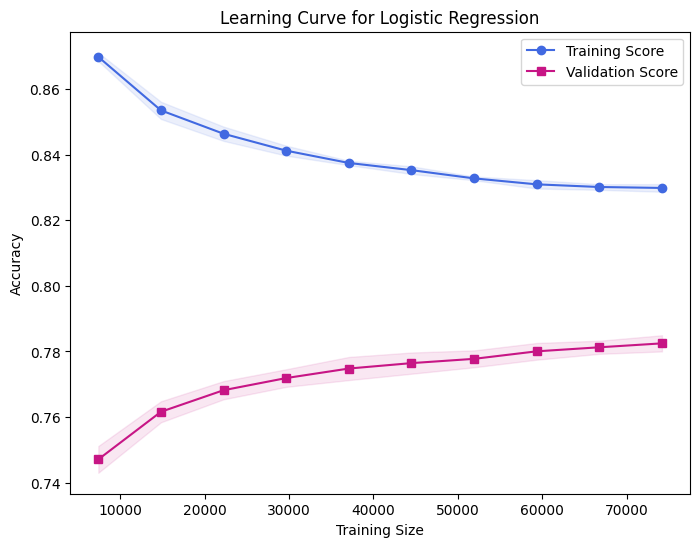

In [30]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(model, x_train_tfidf, train_clean['Label'], cv=2, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10))
# Compute mean and std of accuracy
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="royalblue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="royalblue")

plt.plot(train_sizes, test_mean, label="Validation Score", color="mediumvioletred", marker="s")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="mediumvioletred")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Logistic Regression")
plt.legend()
plt.show()

#### Feature Extraction & Model Development

Use grid search to determine the best parameters for the vectorizer as well as the classifier

In [31]:
pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('model', LogisticRegression())
])

parameters = [{
            'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
            'vectorizer__max_df': [0.7, 0.8, 0.9],
            'vectorizer__min_df': [0.0, 0.00001, 0.001],
            'model__max_iter': [100, 150, 200, 250],
            'model__C': [0.5, 0.7, 1.0, 1.3, 1.5, 1.7, 2.0, 2.5],
            'model__solver': ['lbfgs', 'liblinear', 'saga']
}]

grid_search = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(train_clean['Text'], train_clean['Label'])

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params, best_score)

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits
{'model__C': 2.5, 'model__max_iter': 100, 'model__solver': 'lbfgs', 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 0.0, 'vectorizer__ngram_range': (1, 2)} 0.7969579534929606


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
vectorizer = TfidfVectorizer(max_df=best_params['vectorizer__max_df'], min_df=best_params['vectorizer__min_df'], ngram_range=best_params['vectorizer__ngram_range'])
x_train_tfidf = vectorizer.fit_transform(train_clean['Text'])
x_val_tfidf = vectorizer.transform(val_clean['Text'])

model = LogisticRegression(max_iter=best_params['model__max_iter'], C=best_params['model__C'], random_state=42)
model.fit(x_train_tfidf, train_clean['Label'])

prediction = model.predict(x_val_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Model Evaluation

Accuracy: 0.8062
Precision: 0.8095
Recall: 0.8008
F1 Score: 0.8051
Confusion Matrix: 
[[17203  3994]
 [ 4223 16976]]


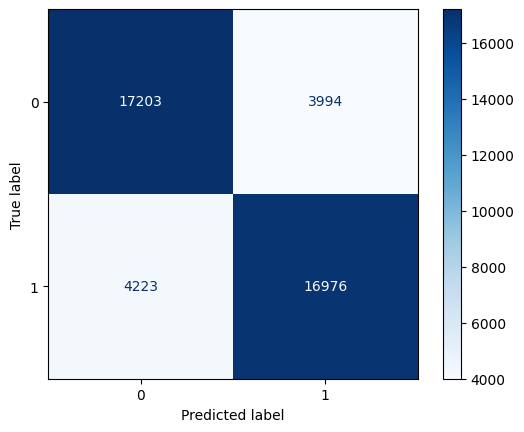

In [33]:
accuracy = accuracy_score(val_clean['Label'], prediction)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(val_clean['Label'], prediction)
print(f"Precision: {precision:.4f}")

recall = recall_score(val_clean['Label'], prediction)
print(f"Recall: {recall:.4f}")

f1 = f1_score(val_clean['Label'], prediction)
print(f"F1 Score: {f1:.4f}")

conf = confusion_matrix(val_clean['Label'], prediction)
print(f"Confusion Matrix: \n{conf}")

_ = ConfusionMatrixDisplay.from_estimator(model, x_val_tfidf, val_clean['Label'], cmap='Blues')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

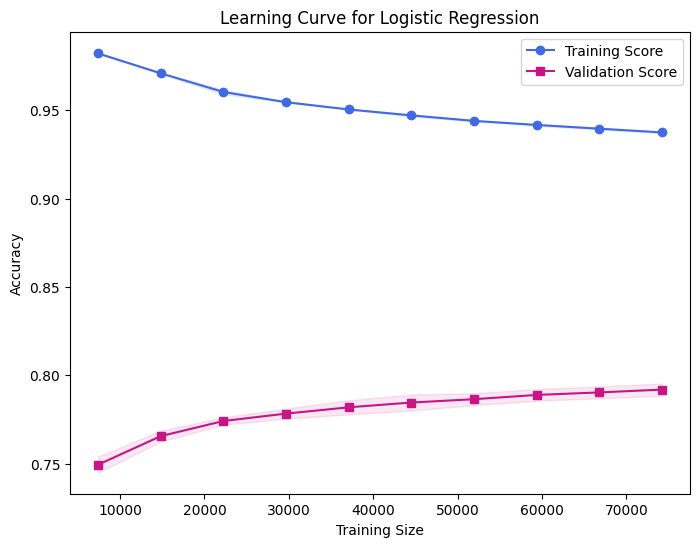

In [34]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(model, x_train_tfidf, train_clean['Label'], cv=2, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10))
# Compute mean and std of accuracy
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="royalblue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="royalblue")

plt.plot(train_sizes, test_mean, label="Validation Score", color="mediumvioletred", marker="s")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="mediumvioletred")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Logistic Regression")
plt.legend()
plt.show()

In [35]:
x_test_tfidf = vectorizer.transform(test_clean['Text'])
test_prediction = model.predict(x_test_tfidf)
output = pd.DataFrame(data=test_clean['ID'])
output['Label'] = test_prediction
output.to_csv('submission.csv', index=False)

#### Appendix

Below is the code that was implemented but not used, as it does not improve the model

Remove all links to websites (either http(s):// or www. links)

In [36]:
# train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'http(s)?\:\/\/\S+', '', x))
# val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
# test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))

# train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'www\.\S+\.[a-z]+', '', x))
# val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'www\.\S+\.[a-z]+', '', x))
# test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'www\.\S+\.[a-z]+', '', x))

Remove emails

In [37]:
# train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'\S+@\w+.\w+', '', x))
# val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'\S+@\w+.\w+', '', x))
# test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'\S+@\w+.\w+', '', x))

Remove twitter handles

In [38]:
# train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'@\S+', '', x))
# val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'@\S+', '', x))
# test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'@\S+', '', x))

Remove all digits

In [39]:
# train_clean.Text = train_clean.Text.apply(lambda x: re.sub(r'[\d]', '', x))
# val_clean.Text = val_clean.Text.apply(lambda x: re.sub(r'[\d]', '', x))
# test_clean.Text = test_clean.Text.apply(lambda x: re.sub(r'[\d]', '', x))

Remove stopwords

In [40]:
# stop = stopwords.words('english')

# def remove_stopwords(text):
#     words = text.split()
#     final = [word for word in words if word not in stop]
#     return " ".join(final)

# train_clean['Text'] = train_clean['Text'].apply(remove_stopwords)
# val_clean['Text'] = val_clean['Text'].apply(remove_stopwords)
# test_clean['Text'] = test_clean['Text'].apply(remove_stopwords)

Use stemming

In [41]:
# stemmer = SnowballStemmer(language='english')
# def stem(text):
#     words = text.split()
#     stemmed_words = [stemmer.stem(w) for w in words]
#     return " ".join(stemmed_words)

# train_clean['Text'] = train_clean['Text'].apply(stem)
# val_clean['Text'] = val_clean['Text'].apply(stem)
# test_clean['Text'] = test_clean['Text'].apply(stem)